In [1]:
from IPython.display import clear_output

# https://www.dgl.ai/pages/start.html

# !pip install dgl
!pip install dgl-cu111 -f https://data.dgl.ai/wheels/repo.html # FOR CUDA VERSION
!pip install dgllife
!pip install rdkit-pypi
!pip install --pre deepchem
!pip install ipython-autotime
!pip install gputil
!pip install psutil
!pip install humanize

%load_ext autotime

clear = clear_output()

time: 4.76 ms (started: 2021-11-30 11:25:19 +00:00)


In [2]:
import os
from os import path
import statistics
import warnings
import random
import time 
import itertools
import psutil
import humanize
import GPUtil as GPU
import subprocess
from datetime import datetime, timedelta

import matplotlib.pyplot as plt

import pandas as pd
import numpy as np

import tqdm
from tqdm import trange, tqdm_notebook, tnrange

import deepchem as dc
import rdkit
from rdkit import Chem
from rdkit.Chem.MolStandardize import rdMolStandardize

# embedding
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.profiler import profile, record_function, ProfilerActivity
from torch.utils.tensorboard import SummaryWriter


import sklearn
from sklearn.metrics import (auc, roc_curve, roc_auc_score, average_precision_score, 
                             accuracy_score, ConfusionMatrixDisplay, confusion_matrix, precision_recall_curve, 
                             f1_score, PrecisionRecallDisplay)
from sklearn.ensemble import RandomForestClassifier

warnings.filterwarnings("ignore", message="DGLGraph.__len__")

DGLBACKEND = 'pytorch'

clear

def get_cmd_output(command):
  return subprocess.check_output(command,
                        stderr=subprocess.STDOUT,
                        shell=True).decode('UTF-8')

time: 8.25 s (started: 2021-11-30 11:25:19 +00:00)


In [3]:
def load_dataset(dataset, bonds=False, feat='graph', create_new=False):
  """
    dataset values: muv, tox21, dude-gpcr
    feat values: graph, ecfp
  """
  dataset_test_tasks = {
    'tox21': ['SR-HSE', 'SR-MMP', 'SR-p53'],
    'muv': ['MUV-832', 'MUV-846', 'MUV-852', 'MUV-858', 'MUV-859'],
    'dude-gpcr': ['adrb2', 'cxcr4']
  }

  dataset_original = dataset

  if bonds:
    dataset = dataset + "_with_bonds"

  if path.exists(f"{drive_path}/data/{dataset}_dgl.pkl") and not create_new:
    # Load Dataset
    print("Reading Pickle")
    if feat == 'graph':
      data = pd.read_pickle(f"{drive_path}/data/{dataset}_dgl.pkl")
    else:
      data = pd.read_pickle(f"{drive_path}/data/{dataset}_ecfp.pkl")
  else:
    # Create Dataset
    df = pd.read_csv(f"{drive_path}/data/raw/{dataset_original}.csv")
    if feat == 'graph':
      data = create_dataset(df, f"{dataset}_dgl", bonds)
    else:
      data = create_ecfp_dataset(df, f"{dataset}_ecfp")

  test_tasks = dataset_test_tasks.get(dataset_original)
  drop_cols = test_tasks.copy()
  drop_cols.extend(['mol_id', 'smiles', 'mol'])
  train_tasks = [x for x in list(data.columns) if x not in drop_cols]

  train_dfs = dict.fromkeys(train_tasks)
  for task in train_tasks:
      df = data[[task, 'mol']].dropna()
      df.columns = ['y', 'mol']
      # FOR BOND INFORMATION
      if with_bonds:
        for index, r in df.iterrows():
          if r.mol.edata['edge_feats'].shape[-1] < 17:
            df.drop(index, inplace=True)
      train_dfs[task] = df
  for key in train_dfs:
    print(key, len(train_dfs[key]))

  if feat == 'graph':
    feat_length = data.iloc[0].mol.ndata['feats'].shape[-1]
    print("Feature Length", feat_length)

    if with_bonds:
      feat_length = data.iloc[0].mol.edata['edge_feats'].shape[-1]
      print("Feature Length", feat_length)
    else:
      print("Edge Features: ", with_bonds)

  test_dfs = dict.fromkeys(test_tasks)

  for task in test_tasks:
      df = data[[task, 'mol']].dropna()
      df.columns = ['y', 'mol']

      # FOR BOND INFORMATION
      if with_bonds:
        for index, r in df.iterrows():
          if r.mol.edata['edge_feats'].shape[-1] < 17:
            df.drop(index, inplace=True)

      test_dfs[task] = df

  for key in test_dfs:
    print(key, len(test_dfs[key]))

  # return data, train_tasks, test_tasks
  return train_dfs, test_dfs

time: 64.1 ms (started: 2021-11-30 11:25:27 +00:00)


## Initiate Training and Testing

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive
time: 1min 13s (started: 2021-11-30 11:25:27 +00:00)


In [5]:
drive_path = "/content/drive/MyDrive/Colab Notebooks/MSC_21"
method_dir = "RandomForest"
log_path = f"{drive_path}/{method_dir}/logs/"

# PARAMETERS
# dude-gprc, tox21, muv
dataset = 'dude-gpcr'
with_bonds = False 
rounds = 20
n_query = 64 # per class
episodes = 10000
lr = 0.001
balanced_queries = True

randomseed = 12
torch.manual_seed(randomseed) 
np.random.seed(randomseed)
random.seed(randomseed)
torch.cuda.manual_seed(randomseed)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
torch.backends.cudnn.is_available()
torch.backends.cudnn.benchmark = False # selects fastest conv algo
torch.backends.cudnn.deterministic = True

combinations = [
    [10, 10],
    [5, 10], 
    [1, 10], 
    [1, 5], 
    [1, 1]
]

cols = [
  'DATE', 'CPU', 'CPU COUNT',	'GPU', 'GPU RAM',	'RAM',	'CUDA',	
  'REF', 'DATASET', 'ARCHITECTURE',	
  'SPLIT',	'TARGET',	'ACCURACY',	'ROC',	'PRC',
  'TRAIN ROC',	'TRAIN PRC',	'EPISODES',	'TRAINING TIME', 'ROC_VALUES', 'PRC_VALUES'
]

time: 81.1 ms (started: 2021-11-30 11:26:41 +00:00)


In [6]:
train_dfs, test_dfs = load_dataset(dataset, bonds=with_bonds, feat='ecfp', create_new=False)

Reading Pickle
aa2ar 32032
drd3 34530
adrb1 16097
adrb2 15231
cxcr4 3446
time: 6.56 s (started: 2021-11-30 11:26:56 +00:00)


In [7]:
dt_string = datetime.now().strftime("%d/%m/%Y %H:%M:%S")
cpu = get_cmd_output('cat /proc/cpuinfo | grep -E "model name"')
cpu = cpu.split('\n')[0].split('\t: ')[-1]
cpu_count = psutil.cpu_count()
cuda_version = get_cmd_output('nvcc --version | grep -E "Build"')
gpu = get_cmd_output("nvidia-smi -L")
general_ram_gb = humanize.naturalsize(psutil.virtual_memory().available)
gpu_ram_total_mb = GPU.getGPUs()[0].memoryTotal

for c in combinations:
  n_pos = c[0]
  n_neg = c[1]
  results = pd.DataFrame(columns=cols)

  for target in test_dfs.keys():
    print(target)

    running_roc = []
    running_prc = []
    for round in trange(rounds):
      start_time = time.time()
      df = test_dfs[target]
      support_neg = df[df['y'] == 0].sample(n_neg)
      support_pos = df[df['y'] == 1].sample(n_pos)

      train_data = pd.concat([support_neg, support_pos])
      test_data = df.drop(train_data.index)

      train_data = train_data.sample(frac=1)
      test_data = test_data.sample(frac=1)

      train_X, train_y = list(train_data['mol'].to_numpy()), train_data['y'].to_numpy(dtype=np.int16)
      test_X, test_y = list(test_data['mol'].to_numpy()), test_data['y'].to_numpy(dtype=np.int16)
      
      model = RandomForestClassifier(n_estimators=100)
      model.fit(train_X, train_y)
      probs_y = model.predict_proba(test_X)

      roc = roc_auc_score(test_y, probs_y[:, 1])
      prc = average_precision_score(test_y, probs_y[:, 1])

      running_roc.append(roc)
      running_prc.append(prc)
      end_time = time.time()
      duration = str(timedelta(seconds=(end_time - start_time)))
      
    rounds_roc = f"{statistics.mean(running_roc):.3f} \u00B1 {statistics.stdev(running_roc):.3f}"
    rounds_prc = f"{statistics.mean(running_prc):.3f} \u00B1 {statistics.stdev(running_prc):.3f}"
    rec = pd.DataFrame([[dt_string, cpu, cpu_count, gpu, gpu_ram_total_mb, general_ram_gb, cuda_version, "MSC", 
                        dataset, method_dir, f"{n_pos}+/{n_neg}-", target, 0, rounds_roc, rounds_prc, 
                        0, 0, 0, duration, running_roc, running_prc
          ]], columns=cols)

    results = pd.concat([results, rec])

  results.to_csv(f"{drive_path}/results/{dataset}_{method_dir}_pos{n_pos}_neg{n_neg}.csv", index=False)

adrb2


100%|██████████| 20/20 [00:06<00:00,  3.02it/s]


cxcr4


100%|██████████| 20/20 [00:03<00:00,  5.99it/s]


adrb2


100%|██████████| 20/20 [00:06<00:00,  3.21it/s]


cxcr4


100%|██████████| 20/20 [00:03<00:00,  6.13it/s]


adrb2


100%|██████████| 20/20 [00:05<00:00,  3.65it/s]


cxcr4


100%|██████████| 20/20 [00:03<00:00,  6.38it/s]


adrb2


100%|██████████| 20/20 [00:05<00:00,  3.65it/s]


cxcr4


100%|██████████| 20/20 [00:03<00:00,  6.32it/s]


adrb2


100%|██████████| 20/20 [00:05<00:00,  3.81it/s]


cxcr4


100%|██████████| 20/20 [00:03<00:00,  6.43it/s]


time: 46.6 s (started: 2021-11-30 11:27:14 +00:00)


In [134]:
# model.score(test_X, test_y)
# pred_y = model.predict(test_X)
# model.classes_

0.816580310880829

time: 140 ms (started: 2021-11-25 11:45:45 +00:00)


In [8]:
from sklearn.metrics import confusion_matrix
preds = model.predict(test_X)
confusion_matrix(test_y, preds)

array([[3375,   30],
       [  25,   14]])

time: 50.6 ms (started: 2021-11-30 11:28:01 +00:00)


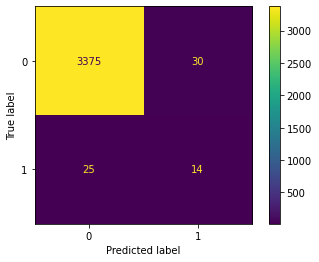

time: 188 ms (started: 2021-11-30 11:28:01 +00:00)


In [9]:
ConfusionMatrixDisplay.from_predictions(test_y, preds)